# Pavli et al. Dump Cooled Engine

Comparison with data for test firing 9, from Pavli's dump-cooled engine paper.

### Notes:
- There is a chance the coolant chokes at M = 1 in the cooling channels, and then goes supersonic. This would explain the overprediction of the coolant static temperature and pressure.

### References:

- [1] - Pavli et al. 1966, Design and Cooling Performance of a Dump-Cooled Rocket Engine (https://ntrs.nasa.gov/citations/19660022898)
- [2] - NASA CEA (https://cearun.grc.nasa.gov/)

In [1]:
import bamboo as bam
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import json

data = json.load(open("data/pavli.json"))

In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})

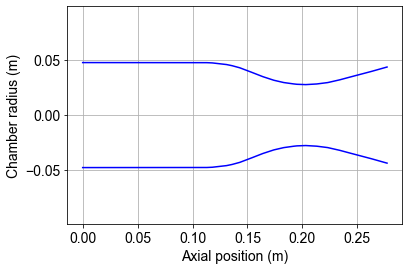

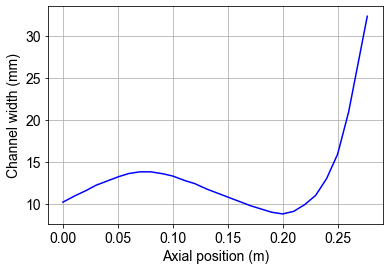

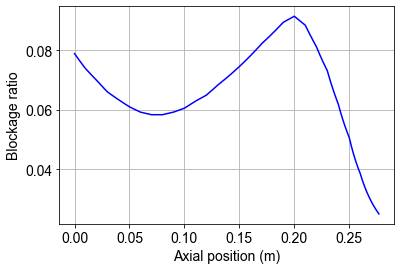

In [3]:
# Combustion chamber (firing 9) [1]
OF = 5.01
p0_chamber = 7.91e5
T0_chamber = 2939      # Note NASA's CEA predicts a value of 3172.47 K

# Use NASA CEA to get the gas properties at the throat [2]
cp = 4063.1       # Isobaric specific heat capacity, J/kg/K
gamma = 1.2163    # Ratio of specific heats cp/cv

xs = data["Chamber Contour"]["x (m)"]
ys = data["Chamber Contour"]["y (m)"]

# Cooling channels [1]
wall_thickness = 2.54e-3
wall_material = bam.materials.StainlessSteel304
number_of_channels = 8
mdot_coolant = 0.0644
p_coolant_in = data["Coolant static pressure"]["p (Pa)"][0]  # Designed for 10.3e5 Pa
T_coolant_in = data["Coolant temperature"]["T (K)"][0]       # Designed for 31.7 K
channel_height = 2.54e-3

def channel_width(x):
    return np.interp(x, data["Channel width"]["x (m)"], data["Channel width"]["w (m)"])

def blockage_ratio(x):
    area = channel_width(x) * channel_height
    return 2.045e-6 / area
    
plt.plot(xs, ys, color = 'blue')
plt.plot(xs, -np.array(ys), color = 'blue')
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Chamber radius (m)")
plt.axis('equal')
plt.savefig("img/pavli/contour.svg", bbox_inches = "tight")
plt.show()

plt.plot(xs, 1e3 * channel_width(xs), color = "blue")
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Channel width (mm)")
plt.savefig("img/pavli/channel_width.svg", bbox_inches = "tight")
plt.show()

plt.plot(xs, blockage_ratio(xs), color = "blue")
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Blockage ratio")
plt.savefig("img/pavli/blockage_ratio.svg", bbox_inches = "tight")
plt.show()

In [4]:
# Cantera for exhaust gas
gas = ct.Solution('gri30.yaml')
gas.TPY = T0_chamber, p0_chamber, f"H2:{1}, O2:{OF}"
gas.equilibrate("TP")

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity

In [5]:
# CoolProp for coolant transport properties
def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN") 

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN") 

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN") 

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

    
def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 


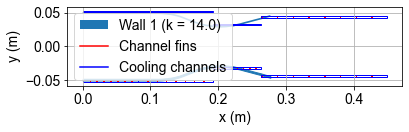

In [6]:
# Set up everything for bamboo
geometry = bam.Geometry(xs = xs, 
                        rs = ys)

perfect_gas = bam.PerfectGas(gamma = gamma, 
                             cp = cp)   

chamber_conditions = bam.ChamberConditions(p0 = p0_chamber, 
                                           T0 = T0_chamber)

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

cooling_jacket = bam.CoolingJacket(T_coolant_in = T_coolant_in,                           
                                   p_coolant_in = p_coolant_in, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "spiral", 
                                   channel_height = channel_height,
                                   channel_width = channel_width,
                                   number_of_channels = number_of_channels,
                                   blockage_ratio = blockage_ratio)

wall = bam.Wall(material = wall_material, 
                thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall)

engine.plot()

In [7]:
# Run simulation
bamboo_data = engine.steady_heating_analysis(counterflow = False)

### Plots

Comparison of Bamboo data with experimental data.

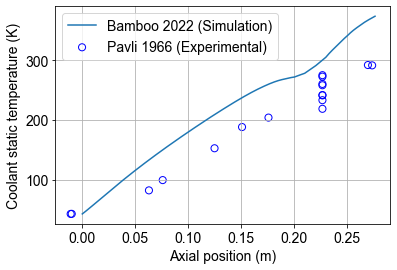

Experimental coolant exit temperature (Pavli) = 291.67 K
Predicted coolant exit temperature (Bamboo) = 373.96 K

Absolute error in coolant exit temperature = 82.29700238640527 K
Percentage error in coolant temperature rise = 33.06573343480822%



In [8]:
plt.plot(bamboo_data["x"], bamboo_data["T_coolant"], label = "Bamboo 2022 (Simulation)")

plt.scatter(data["Coolant temperature"]["x (m)"], 
            data["Coolant temperature"]["T (K)"],
            marker = 'o',
            facecolors='none',
            s = 50,
            color = 'blue',
            label = "Pavli 1966 (Experimental)")

plt.xlabel("Axial position (m)")
plt.ylabel("Coolant static temperature (K)")

plt.grid()
plt.legend()
plt.savefig("img/pavli/T_coolant.svg", bbox_inches = "tight")
plt.show()

print(f'Experimental coolant exit temperature (Pavli) = {data["Coolant temperature"]["T (K)"][-1]:.2f} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_data["T_coolant"][-1]:.2f} K')

dT_pavli = abs(data["Coolant temperature"]["T (K)"][-1] - data["Coolant temperature"]["T (K)"][0])
dT_bamboo = abs(bamboo_data["T_coolant"][-1] - bamboo_data["T_coolant"][0])

print(f'\nAbsolute error in coolant exit temperature = {bamboo_data["T_coolant"][-1] - data["Coolant temperature"]["T (K)"][-1]} K')
print(f'Percentage error in coolant temperature rise = {100 * (dT_bamboo - dT_pavli)/dT_pavli}%\n')

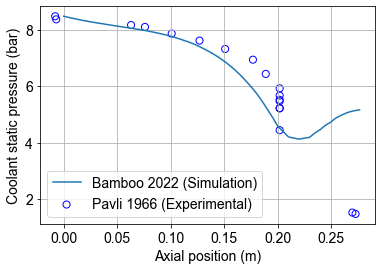

In [9]:
plt.plot(bamboo_data["x"], np.array(bamboo_data["p_coolant"])/1e5, label = "Bamboo 2022 (Simulation)")

plt.scatter(data["Coolant static pressure"]["x (m)"], 
            np.array(data["Coolant static pressure"]["p (Pa)"])/1e5,
            marker = 'o',
            facecolors='none',
            s = 50,
            color = 'blue',
            label = "Pavli 1966 (Experimental)")

plt.ylabel("Coolant static pressure (bar)")
plt.xlabel("Axial position (m)")
plt.grid()
plt.legend()

plt.savefig("img/pavli/p_coolant.svg", bbox_inches = "tight")
plt.show()

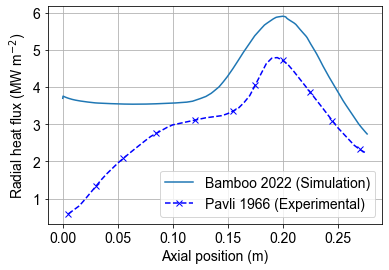

Peak heat transfer rate (Pavli) = 4.789605505 MW/m^2
Peak heat transfer rate (Bamboo) = 5.900619284406974 MW/m2
Percentage error in peak heat transfer rate = 23.196352564885697%


In [10]:
plt.plot(bamboo_data["x"], np.array(bamboo_data["dQ_dA"])/1e6, label = "Bamboo 2022 (Simulation)")

plt.plot(data["Heat flux"]["x (m)"], 
         np.array(data["Heat flux"]["q (W/m2)"])/1e6, 
         color = "blue", 
         label = "Pavli 1966 (Experimental)", 
         linestyle = "--",
         marker = "x",
         markevery = 0.1)

plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel(r"Radial heat flux (MW m$^{-2}$)")
plt.legend()

plt.savefig("img/pavli/dQ_dA.svg", bbox_inches = "tight")
plt.show()

q_max_pavli = max(data["Heat flux"]["q (W/m2)"])
q_max_bamboo = max(bamboo_data["dQ_dA"])

print(f'Peak heat transfer rate (Pavli) = {q_max_pavli/1e6} MW/m^2')
print(f'Peak heat transfer rate (Bamboo) = {q_max_bamboo/1e6} MW/m2')
print(f'Percentage error in peak heat transfer rate = {100*(q_max_bamboo - q_max_pavli) / q_max_pavli}%')

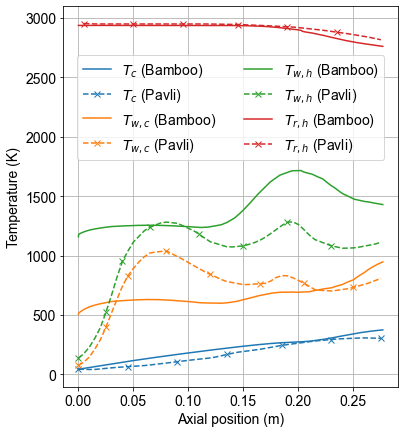

In [11]:
#plt.rcParams.update({'font.size': 18})

#plt.plot(data["Predicted temperatures"]["x (m)"], data["Predicted temperatures"]["Twh2 (K)"], color = "green", linestyle = "--")
plt.figure(figsize=(6,7))


plt.plot(bamboo_data["x"], np.array(bamboo_data["T"])[:,0], label = r"$T_{c}$ (Bamboo)")
plt.plot(data["Predicted temperatures"]["x (m)"], 
         data["Predicted temperatures"]["Tc (K)"], 
         color = "C0", 
         linestyle = "--",
         label = r"$T_{c}$ (Pavli)",
         marker = "x",
         markevery = 0.1)

plt.plot(bamboo_data["x"], np.array(bamboo_data["T"])[:,1], label = r"$T_{w,c}$ (Bamboo)")
plt.plot(data["Predicted temperatures"]["x (m)"], 
         data["Predicted temperatures"]["Twc (K)"], 
         color = "C1", 
         linestyle = "--",
         label = r"$T_{w,c}$ (Pavli)",
         marker = "x",
         markevery = 0.1)

plt.plot(bamboo_data["x"], np.array(bamboo_data["T"])[:,2], label = r"$T_{w,h}$ (Bamboo)")
plt.plot(data["Predicted temperatures"]["x (m)"], 
         data["Predicted temperatures"]["Twh1 (K)"], 
         color = "C2", 
         linestyle = "--",
         label = r"$T_{w,h}$ (Pavli)",
         marker = "x",
         markevery = 0.1)

plt.plot(bamboo_data["x"], np.array(bamboo_data["T"])[:,3], label = r"$T_{r,h}$ (Bamboo)")
plt.plot(data["Predicted temperatures"]["x (m)"][1:], 
         data["Predicted temperatures"]["Th (K)"][1:], # First datapoint has a NaN
         color = "C3", 
         linestyle = "--",
         label = r"$T_{r,h}$ (Pavli)",
         marker = "x",
         markevery = 0.1)

plt.grid()
#plt.legend(loc = "upper left")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size': 14}, ncol = 2, bbox_to_anchor = [0.98, 0.89])
plt.xlabel("Axial position (m)")
plt.ylabel("Temperature (K)")

plt.savefig("img/pavli/temperatures.svg", bbox_inches = "tight")

plt.show()


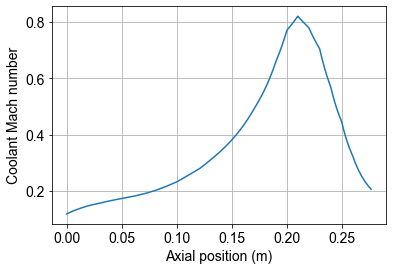

We are very close to Mach 1 (maximum M = 0.8202526362203977).
In the actual experiment the coolant may have sonically choked, and then expanded, creating the pressure drop seen.


In [12]:
V_c = bamboo_data["V_coolant"]
T_c = bamboo_data["T_coolant"]
p_c = bamboo_data["p_coolant"]
speed_of_sound_c = PropsSI("SPEED_OF_SOUND", "T", T_c, "P", p_c, "HYDROGEN") 
M_c = np.array(V_c) / speed_of_sound_c

plt.plot(bamboo_data["x"], M_c)
plt.grid()
plt.ylabel("Coolant Mach number")
plt.xlabel("Axial position (m)")
plt.show()

print(f"We are very close to Mach 1 (maximum M = {max(M_c)}).")
print(f"In the actual experiment the coolant may have sonically choked, and then expanded, creating the pressure drop seen.")